In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

# 1. Synthetic dataset - proof of concept

Classifer is building a graph. Data dimensionality detected is 2. regularity = 6
Classifier graph is build in 23.239s


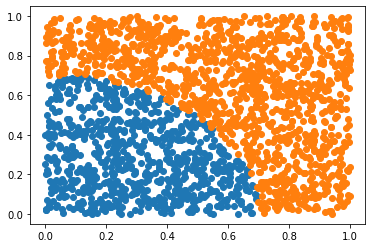

In [2]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

In [3]:
test = dg.gen(N=200, border=0.7)

path, knn = 0, 0
for t in test:
    path += classifier.classify_by_path(t[0], attempts=1) == t[1]
    knn += classifier.classify_knn(t[0], attempts=1) == t[1]
    
print(f"Path classifier accuracy = {100 * path / len(test):.2f}%")
print(f"Knn classifier accuracy = {100 * knn / len(test):.2f}%")

Path classifier accuracy = 99.00%
Knn classifier accuracy = 98.50%


# 2. Simple case: MINST

In [4]:
!python -m pip install mnist

In [5]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train, test = XY[:4 * len(XY) // 5], XY[4 * len(XY) // 5:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train, attempts=20)

Classifer is building a graph. Data dimensionality detected is 64. regularity = 192
Classifier graph is build in 134.907s


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
MNIST: Path classifier accuracy = 98.61%
MNIST: Knn classifier accuracy = 98.33%


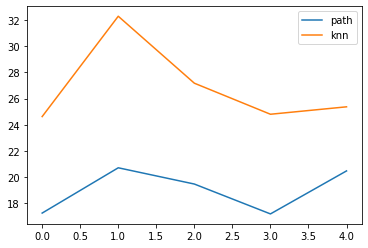

In [6]:
import time

path_times, knn_times = [], []
path, knn = 0, 0
times = 5

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += minst_classifier.classify_by_path(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += minst_classifier.classify_knn(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"MNIST: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"MNIST: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

# 3. Harder case: CIFAR-10

In [3]:
import shutil
import requests
import tarfile

filename = "cifar-10-python.tar.gz"
cifar_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

if not os.path.exists(filename):
    response = requests.get(cifar_url, stream=True)
    with open('cifar-10-python.tar.gz', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()

In [18]:
import pickle, numpy as np
folder = "cifar-10-batches-py"

datas = []
labels = []

for i in range(1, 6):
    with open(f"{folder}/data_batch_{i}", 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        X, Y = batch[b'data'], [[x] for x in batch[b'labels']]
        datas.append(X)
        labels.append(Y)
        
with open(f"{folder}/test_batch", 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
    Xtest, Ytest = batch[b'data'], [[x] for x in batch[b'labels']]
       
X = np.vstack(datas)
X = X - np.ones(X.shape) * 128
Y = np.vstack(labels)
print(X.shape, Y.shape)
XY = np.hstack((X, Y))
np.random.shuffle(XY)
X, Y = XY[:, :3072], XY[:, -1]

Xtest = Xtest - np.ones(Xtest.shape) * 128

# im = X[1].reshape(3, 32, 32)
# im = np.moveaxis(im, 0, -1)
# plt.imshow(im)
# plt.show()

(50000, 3072) (50000, 1)


## 3.1. Reduce dimensions
Create a classifier

In [5]:
from sklearn.neural_network import MLPClassifier

ann_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), random_state=1, max_iter=10, verbose=True, activation="tanh")

Fit the classifier

In [6]:
ann_classifier.fit(X, Y.flatten())

Iteration 1, loss = 2.07798005
Iteration 2, loss = 1.97681857
Iteration 3, loss = 1.94066987
Iteration 4, loss = 1.93019065
Iteration 5, loss = 1.91478911
Iteration 6, loss = 1.91061357
Iteration 7, loss = 1.90077521
Iteration 8, loss = 1.89111708
Iteration 9, loss = 1.87527658
Iteration 10, loss = 1.87197257


C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 32), max_iter=10,
              random_state=1, verbose=True)

Use classifier for dimensionality reduction

In [26]:
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.neural_network._base import ACTIVATIONS
# https://stackoverflow.com/questions/46728937/retrieve-final-hidden-activation-layer-output-from-sklearns-mlpclassifier

def get_activations(clf, X):
        hidden_layer_sizes = list(clf.hidden_layer_sizes)
        hidden_activation = ACTIVATIONS[clf.activation]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(safe_sparse_dot(activations[i], clf.coefs_[i]))
            activations[i+1] += clf.intercepts_[i]
            if (i + 1) != (clf.n_layers_ - 1):
                v = hidden_activation(activations[i+1])

        return activations

Xr = np.array([get_activations(ann_classifier, vec)[-2] for vec in X])
Xtestr = np.array([get_activations(ann_classifier, vec)[-2] for vec in Xtest])

XY = list(zip(Xr, Y))
test = list(zip(Xtestr, Ytest))
test_orig = list(zip(Xtest, Ytest))
ann_classifier.predict(test_orig[100][0].reshape(1, -1)) == test_orig[100][1]

array([ True])

In [ ]:
cifar_classifier = NSWClassifier()
cifar_classifier.build_navigable_graph(XY, attempts=10, verbose=True)

path_times, knn_times, ann_times = [], [], []
path, knn, ann = 0, 0, 0
times = 3

print(cls.predict(t[0])[0])

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += cifar_classifier.classify_by_path(t[0], attempts=1)[0] == t[1][0]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += cifar_classifier.classify_knn(t[0], attempts=1)[0] == t[1][0]
    f = time.perf_counter()
    knn_times.append(f - s)
    
    s = time.perf_counter()
    for t, to in test, test_orig:
        ann += cls.predict(to[0].reshape(1, -1))[0] == t[1][0]
    f = time.perf_counter()
    ann_times.append(f - s)

        
print(f"CIFAR-10: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"CIFAR-10: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")
print(f"CIFAR-10: ANN classifier accuracy = {100 * ANN / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

Classifier is building a graph. Data dimensionality detected is 32. regularity = 96
	10.00% of graph construction
